In [1]:
import numpy as np
import pandas as pd
import time
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from collections import deque
import matplotlib.pyplot as plt

In [2]:
Data = pd.read_csv('399300.csv',parse_dates=[0],index_col=[0])
Data['Adj Close'] = Data['Close']
Data['Adj_High'] = Data['High'] * Data['Adj Close'] / Data['Close']
Data['Adj_Low'] = Data['Low'] * Data['Adj Close'] / Data['Close']
Data['Adj_Open'] = Data['Open'] * Data['Adj Close'] / Data['Close']
pre_days = -10
#Data['label'] = Data['Close'].shift(pre_days)
Data = Data.drop(['Open', 'High', 'Low', 'Close','Volume'], axis=1)
dpIndex = []
dpIndex.extend(Data.index[-11:-1])
dpIndex.append(Data.index[-1])
Data = Data.drop(index = dpIndex )
Data.tail(10)

,Adj Close,Adj_High,Adj_Low,Adj_Open
Time,,,,
2022-02-16,4617.9893,4643.1003,4607.2178,4619.8458
2022-02-17,4629.1649,4650.1591,4606.9522,4616.8955
2022-02-18,4651.2358,4651.3415,4598.1003,4604.5669
2022-02-21,4634.3141,4646.6724,4613.2971,4646.0522
2022-02-22,4574.1527,4602.0660,4550.8040,4601.9184
2022-02-23,4623.0465,4625.2979,4579.2945,4582.0064
2022-02-24,4529.3189,4610.8792,4488.4763,4592.0690
2022-02-25,4573.4247,4611.8602,4561.8964,4564.6321
2022-02-28,4581.6459,4581.6459,4530.6764,4563.7427


In [4]:
Scale_X = Data.iloc[:,:]
Scale_Y = Data.iloc[:,0]
print(Scale_X.shape)
print(Scale_Y.shape)

(4168, 4)
(4168,)


In [5]:
scaler = MinMaxScaler(feature_range=(-1,1))
data = scaler.fit_transform(Scale_X)
y = np.array(Scale_Y)
y = scaler.fit_transform(y.reshape(-1,1))

(4069, 100, 4) (4069, 1)


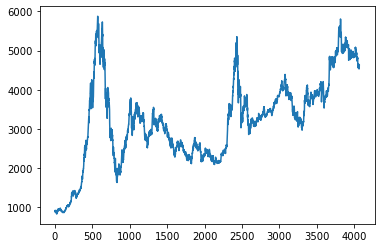

In [6]:
time_steps = 100
X_new = np.zeros((data.shape[0] - time_steps + 1, time_steps, data.shape[1]))
y_new = np.zeros((y.shape[0] - time_steps + 1, 1))
for ix in range(X_new.shape[0]):
    for jx in range(time_steps):
        X_new[ix, jx, :] = data[ix + jx, :]
    y_new[ix] = y[ix + time_steps -1]
print(X_new.shape, y_new.shape)
plt.plot(scaler.inverse_transform(y_new))

In [9]:
split = int(0.8 * data.shape[0])
X_train = X_new[:split]
X_test = X_new[split:]

Y_train = y_new[:split]
Y_test = y_new[split:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3334, 100, 4) (3334, 1)
(735, 100, 4) (735, 1)


In [10]:
X_train = torch.from_numpy(X_train).type(torch.Tensor)
X_test = torch.from_numpy(X_test).type(torch.Tensor)
Y_train = torch.from_numpy(Y_train).type(torch.Tensor)
Y_test = torch.from_numpy(Y_test).type(torch.Tensor)

In [11]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

torch.Size([3334, 100, 4]) torch.Size([3334, 1])
torch.Size([735, 100, 4]) torch.Size([735, 1])


In [12]:
class net(nn.Module):
    def __init__(self,input_dim,hidden_dim,num_layers,output_dim,dropout=0.2):
        super(net,self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
       # self.drop = nn.Dropout(dropout)
        #self.conv1d = nn.Conv1d()
        self.lstm = nn.LSTM(input_dim,hidden_dim,num_layers,batch_first = True,dropout=dropout)
        self.function = nn.Linear(hidden_dim,output_dim)
    def forward(self,x):
        #x = self.drop(dt)
        #h0 = torch.zeros(self.num_layers,x.size(0),self.hidden_dim).requires_grad_().cuda()
        #c0 = torch.zeros(self.num_layers,x.size(0),self.hidden_dim).requires_grad_().cuda()
        h0 = torch.zeros(self.num_layers,x.size(0),self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers,x.size(0),self.hidden_dim).requires_grad_()
        out,(hn,cn) = self.lstm(x,(h0.detach(),c0.detach()))
        #从out中获得最终输出的状态h
        out = self.function(out[:,-1,:])
        #out = out.squeeze(-1)
        return out

In [13]:
input_dim = 4
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs =100

In [14]:
model = net(input_dim=input_dim,hidden_dim=hidden_dim,num_layers=num_layers,output_dim=output_dim)
optim = torch.optim.Adam(model.parameters(),lr = 0.01,weight_decay=0.01)

In [15]:
use_gpu = torch.cuda.is_available()
hist = np.zeros(num_epochs)
start_time = time.time()
print(model)

net(
  (lstm): LSTM(4, 32, num_layers=2, batch_first=True, dropout=0.2)
  (function): Linear(in_features=32, out_features=1, bias=True)
)


In [16]:
for i in range(num_epochs):
    if use_gpu:
        model = model.cuda()
        y_train_pred = model(X_train)
        loss = loss = nn.functional.mse_loss(y_train_pred,Y_train)
        loss = loss.cuda()
        print("Epoch",i+1,"MSE",loss.item())
        optim.zero_grad()
        loss.backward()
        optim.step()              
    else:
        y_train_pred = model(X_train)
        #设置损失函数为mse
        loss = loss = nn.functional.mse_loss(y_train_pred,Y_train)
        print("Epoch",i+1,"MSE",loss.item())
        hist[i] = loss.item()
        optim.zero_grad()
        loss.backward()
        optim.step()
training_time = time.time()-start_time
print("Training time:{}".format(training_time))

Epoch 1 MSE 0.14800113439559937
Epoch 2 MSE 0.13253070414066315
Epoch 3 MSE 0.11886508017778397
Epoch 4 MSE 0.09985235333442688
Epoch 5 MSE 0.07439049333333969
Epoch 6 MSE 0.04192992299795151
Epoch 7 MSE 0.01149793155491352
Epoch 8 MSE 0.015445039607584476
Epoch 9 MSE 0.028272630646824837
Epoch 10 MSE 0.017096538096666336
Epoch 11 MSE 0.007436168380081654
Epoch 12 MSE 0.007661540061235428
Epoch 13 MSE 0.01264915894716978
Epoch 14 MSE 0.01767280511558056
Epoch 15 MSE 0.019401397556066513
Epoch 16 MSE 0.017521565780043602
Epoch 17 MSE 0.013369531370699406
Epoch 18 MSE 0.008506093174219131
Epoch 19 MSE 0.005183493252843618
Epoch 20 MSE 0.00446388078853488
Epoch 21 MSE 0.006155202630907297
Epoch 22 MSE 0.007121937815099955
Epoch 23 MSE 0.005742227658629417
Epoch 24 MSE 0.004113259259611368
Epoch 25 MSE 0.0041063278913497925
Epoch 26 MSE 0.005586517509073019
Epoch 27 MSE 0.007278287783265114
Epoch 28 MSE 0.00811404176056385
Epoch 29 MSE 0.006983078084886074
Epoch 30 MSE 0.005396871361881494

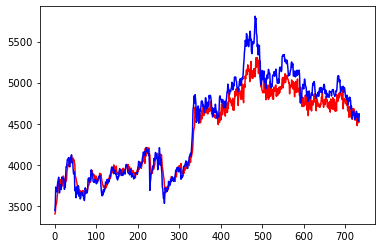

In [20]:
y_test = model(X_test)
y_train = model(X_train)
y_test_pred = scaler.inverse_transform(y_test.detach().numpy())
y_train_pred = scaler.inverse_transform(y_train.detach().numpy())
y_test_real = scaler.inverse_transform(Y_test)
plt.plot(y_test_pred,'r-')
plt.plot(y_test_real,'b-')
#plt.plot(y_train_pred,'g-')
#plt.plot(scaler.inverse_transform(y_new))

In [18]:
import math,time
from sklearn.metrics import mean_squared_error
import plotly.graph_objects as go

In [21]:
lstm = []
y_train_pred = model(X_train)
y_test_pred = model(X_test)
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(Y_train)
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(Y_test.detach().numpy())

In [22]:
memery_days = time_steps

In [23]:
original = scaler.inverse_transform(y.reshape(-1,1))
trainPredictPlot = np.empty_like(y)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[memery_days:len(y_train_pred)+memery_days,:] = y_train_pred
testPredictPlost = np.empty_like(y)
testPredictPlost[:,:] = np.nan
testPredictPlost[len(y_train_pred)-1:len(y_test_pred)+len(y_train_pred)-1,:] = y_test_pred
predictions = np.append(trainPredictPlot,testPredictPlost,axis=1)
predictions = np.append(predictions,original,axis=1)
result = pd.DataFrame(predictions)

In [25]:
import plotly.express as px
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index,y=result[0],mode='lines',name='Train Prediction')))
fig.add_trace(go.Scatter(x=result.index,y=result[1],mode='lines',name='Test Prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index,y=result[2],mode='lines',name='Actual Value')))
fig.update_layout(xaxis = dict(showline=True,showgrid=True,showticklabels=False,linecolor='white',linewidth=2),
                 yaxis = dict(title_text='Close (RMB)',titlefont=dict(family='Rockwell',color='white',),
                             showline=True,showgrid=True,showticklabels=True,linecolor='white',linewidth=2,
                             ticks='outside',tickfont=dict(family='Rockwell',color='white',),),
                 showlegend=True,template = 'plotly_dark')
annotations = []
annotations.append(dict(xref='paper',yref='paper',x=0.0,y=1.05,
                       xanchor='left',yanchor='bottom',text='Result(RNN)',
                       font=dict(family='Rockwell',color='white'),
                       showarrow=False))
fig.update_layout(annotations=annotations)
fig.show()

In [26]:
 torch.save(model.state_dict(),'model.pkl')